# Master de sciences et technologie 1 MU4MA029  
**Mention : Mathématiques et applications 2024–2025**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.tri import Triangulation
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.optimize import curve_fit
import time
from collections import defaultdict


import scipy.integrate
from scipy.integrate import quad
from scipy.sparse import coo_matrix

from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
# Vous pouvez modifier directement ici les trois arguments ci-dessous.
# Les valeurs seront automatiquement prises en compte dans tout le reste du code.

n = 6        # Remarque : choisir n > 1 donne de meilleurs résultats visuels et numériques.
p, q = 1, 1

---

## 1. Géométrie

Nous considérons le domaine suivant :

$$
\Omega := ((0, 2\pi) \times (0, 2\pi)) \setminus \left([\pi/2, 3\pi/2] \times [\pi/2, 3\pi/2] \right) \tag{1}
$$

avec la frontière \\( \Gamma = \Gamma_N \cup \Gamma_D \\), où \\( \Gamma_N \\) désigne la frontière de \\( (0, 2\pi) \times (0, 2\pi) \\) et \\( \Gamma_D \\) désigne la frontière de \\( (\pi/2, 3\pi/2) \times (\pi/2, 3\pi/2) \\).

### (a)

Écrire une routine `GenerateMesh` adaptée de celle du TP2 qui génère un maillage triangulaire structuré uniforme pour \\( \Omega \\).  Les sorties sont : `vtx` (tableau de coordonnées) et `elt` (tableau de connectivité) pour le maillage du domaine \\( \Omega \\) au format du TP2.  
Le maillage doit être construit en générant d’abord un maillage triangulaire uniforme du carré complet \\( (0, 2\pi) \times (0, 2\pi) \\).  Le nombre de points dans chaque direction doit être de la forme \\( N = 4n + 1 \\) avec \\( n \in \mathbb{N} \\).  Ensuite, les nœuds et les triangles (ouverts) ayant une intersection non triviale avec le carré \\( (\pi/2, 3\pi/2) \times (\pi/2, 3\pi/2) \\) doivent être supprimés.  Les indices des nœuds et des éléments doivent être mis à jour, de sorte que les indices des nœuds vont de \\( 0 \\) à \\( N_\Omega - 1 \\), où \\( N_\Omega \\) est le nombre de nœuds dans le maillage de \\( \Omega \\).

In [6]:
def GenerateMesh(n):
    N = 4 * n + 1
    L = 2 * np.pi
    h = L / (N - 1)

    vtx = []
    idx_map = {}
    for j in range(N):
        for i in range(N):
            x = i * h
            y = j * h
            idx = j * N + i
            vtx.append([x, y])
            idx_map[(i, j)] = idx
    vtx = np.array(vtx)

    elt = []
    for j in range(N - 1):
        for i in range(N - 1):
            # Indices des sommets du carré
            p1 = idx_map[(i, j)]
            p2 = idx_map[(i + 1, j)]
            p3 = idx_map[(i, j + 1)]
            p4 = idx_map[(i + 1, j + 1)]

            # Vérification si les triangles traversent le carré central
            tri_centers = [
                (vtx[p1] + vtx[p2] + vtx[p4]) / 3,
                (vtx[p1] + vtx[p4] + vtx[p3]) / 3
            ]

            for center, tri in zip(tri_centers, [[p1, p2, p4], [p1, p4, p3]]):
                x, y = center
                if not (np.pi / 2 <= x <= 3 * np.pi / 2 and np.pi / 2 <= y <= 3 * np.pi / 2):
                    elt.append(tri)

    elt = np.array(elt)

    # Renumérotation des sommets utilisés
    used_nodes = np.unique(elt.flatten())
    old_to_new = {old: new for new, old in enumerate(used_nodes)}
    new_vtx = vtx[used_nodes]
    new_elt = np.array([[old_to_new[i] for i in tri] for tri in elt])

    return new_vtx, new_elt

In [7]:
vtx, elt = GenerateMesh(n)

### (b)

Écrire une routine `PlotMesh` qui peut représenter un maillage triangulaire du domaine \\( \Omega \\) et tracer le nouveau maillage.

In [9]:
def Boundary(elt):
    b = set()
    for c in range(len(elt)):
        kc = elt[c,:]            # 取出当前第 c 个三角形的三个顶点编号
        for j in range(3):
            fj = (kc[j%3], kc[(j+1)%3])       # On extrait les deux sommets d’une arête du triangle courant.
            fj = tuple(np.sort(fj))
            if fj not in b:
                b.add(fj)        # Ajouter une arête si elle n’a pas encore été vue
            else :
                b.remove(fj)     # Si elle a déjà été vue, elle est interne, on la retire
    return np.array(list(b))

def edge_is_outer(i, j):
        for idx in (i, j):
            x, y = vtx[idx]
            xmin, xmax = np.min(vtx[:, 0]), np.max(vtx[:, 0])
            ymin, ymax = np.min(vtx[:, 1]), np.max(vtx[:, 1])
            eps = 1e-8        # Tolérance numérique pour détecter les bords
            if abs(x - xmin) < eps or abs(x - xmax) < eps or abs(y - ymin) < eps or abs(y - ymax) < eps:
                return True   # L’arête est sur le bord extérieur
        return False          # Sinon, elle est sur le bord intérieur

In [10]:
def PlotMesh(vtx, elt):
    eltb = Boundary(elt)
    
    x = vtx[:,0]
    y = vtx[:,1]
    
    plt.figure()
    plt.triplot(x, y, elt, "g-", color = 'black', linewidth=0.8)

    for (i, j) in eltb:
        xi, yi = vtx[i]
        xj, yj = vtx[j]
        color = 'blue' if edge_is_outer(i, j) else 'red'
        plt.plot([xi, xj], [yi, yj], color=color, linewidth=1.2)

    plt.gca().set_aspect('equal')
    plt.plot(vtx[:,0], vtx[:,1], ".", color = "red")
    plt.title("Maillage triangulaire")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(False)
    plt.show()

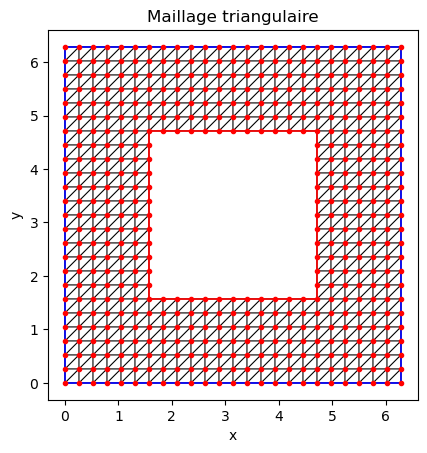

In [11]:
PlotMesh(vtx, elt)

### (c)

Adapter la routine précédente pour représenter le vecteur unitaire normal sortant \\( \mathbf{n} \\) sur toute la frontière \\( \Gamma \\) de \\( \Omega \\).

In [13]:
def compute_normals(vtx, elt, belt):
    """
    Calcule les vecteurs normaux unitaires sortants associés à chaque arête de bord (belt).
    Retourne un tableau de forme (len(belt), 2) contenant les vecteurs normaux.
    """
    # Construction d’un dictionnaire : arête → triangle adjacent
    edge_to_triangle = defaultdict(list)
    for t_idx, tri in enumerate(elt):
        for k in range(3):
            i, j = tri[k], tri[(k + 1) % 3]
            edge = tuple(sorted((i, j)))
            edge_to_triangle[edge].append(t_idx)

    normals = np.zeros((len(belt), 2))

    for idx, (i, j) in enumerate(belt):
        p1, p2 = vtx[i], vtx[j]
        midpoint = (p1 + p2) / 2
        edge_vec = p2 - p1
        tangent = edge_vec / np.linalg.norm(edge_vec)

        # Vecteur normal initial obtenu par rotation de 90 degrés
        normal = np.array([-tangent[1], tangent[0]])

        # Récupération du triangle adjacent (unique car bord)
        tri_idx = edge_to_triangle[tuple(sorted((i, j)))][0]
        tri = elt[tri_idx]
        barycenter = np.mean(vtx[tri], axis=0)

        # Orientation : inversion si le vecteur pointe vers l’intérieur
        if np.dot(midpoint - barycenter, normal) < 0:
            normal = -normal

        normals[idx] = normal

    return normals

In [14]:
def PlotMeshWithNormals(vtx, elt, normal_length=0.2):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect('equal')
    
    belt = Boundary(elt)

    # Tracer les arêtes internes (noires)
    from collections import defaultdict
    edge_to_triangle = defaultdict(list)
    for t_idx, tri in enumerate(elt):
        for k in range(3):
            i, j = tri[k], tri[(k + 1) % 3]
            edge = tuple(sorted((i, j)))
            edge_to_triangle[edge].append(t_idx)
    internal_edges = [e for e, t in edge_to_triangle.items() if len(t) == 2]
    for i, j in internal_edges:
        xi, yi = vtx[i]
        xj, yj = vtx[j]
        ax.plot([xi, xj], [yi, yj], color='black', linewidth=0.5)

    # Déterminer si une arête est extérieure (blue) ou intérieure (red)
    xmin, xmax = np.min(vtx[:, 0]), np.max(vtx[:, 0])
    ymin, ymax = np.min(vtx[:, 1]), np.max(vtx[:, 1])
    eps = 1e-8
    def edge_is_outer(i, j):
        for idx in (i, j):
            x, y = vtx[idx]
            if abs(x - xmin) < eps or abs(x - xmax) < eps or abs(y - ymin) < eps or abs(y - ymax) < eps:
                return True
        return False

    # Calcul des vecteurs normaux unitaires sur le bord
    normals = compute_normals(vtx, elt, belt)

    # Tracer les arêtes du bord et les vecteurs normaux
    for k, (i, j) in enumerate(belt):
        xi, yi = vtx[i]
        xj, yj = vtx[j]
        color = 'blue' if edge_is_outer(i, j) else 'red'
        ax.plot([xi, xj], [yi, yj], color=color, linewidth=1.2)

        midpoint = (vtx[i] + vtx[j]) / 2
        n = normals[k]
        ax.arrow(midpoint[0], midpoint[1],
                 n[0]*normal_length, n[1]*normal_length,
                 head_width=0.05, head_length=0.05,
                 fc=color, ec=color)

    ax.set_title("Maillage avec vecteurs normaux sortants")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

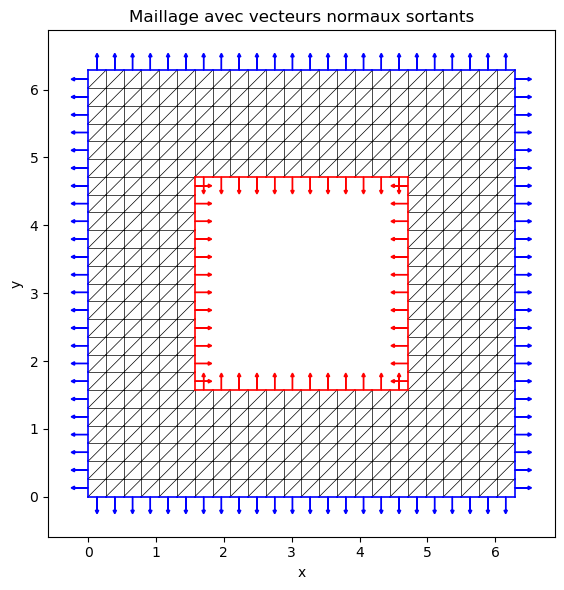

In [15]:
PlotMeshWithNormals(vtx, elt)

---

## 2. Problème d’EDP

Rappelons que \\( \Gamma_N \\) désigne la frontière de \\( (0, 2\pi) \times (0, 2\pi) \\) et \\( \Gamma_D \\) désigne la frontière de \\( (\pi/2, 3\pi/2) \times (\pi/2, 3\pi/2) \\).  
Soit :

$$
\mu(x, y) :=
\begin{cases}
1, & \text{si } y < \pi \\
2, & \text{si } y > \pi
\end{cases} \tag{2}
$$

Soient \\( p, q \in \mathbb{N} \\), alors :

$$
f(x, y) := \left[4(p^2 + q^2) + \mu(x,y)\right] \sin(2px)\sin(2qy), \quad \forall (x, y) \in \Omega \tag{3}
$$

$$
u_{\text{ex}}(x, y) := \sin(2px)\sin(2qy), \quad \forall (x, y) \in \Omega \tag{4}
$$

Nous considérons le modèle d’EDP du second ordre suivant :

$$
\begin{cases}
-\Delta u + \mu u = f, & \text{dans } \Omega \\
u = 0, & \text{sur } \Gamma_D \\
\partial_n u = \partial_n u_{\text{ex}}, & \text{sur } \Gamma_N
\end{cases} \tag{5}
$$

Nous voulons calculer une solution approchée \\( u_h \\) du problème ci-dessus en utilisant une méthode de Galerkin conforme.  
L’espace d’approximation de dimension finie \\( V_h \\) est construit en utilisant des éléments finis de Lagrange \\( \mathbb{P}_1 \\) sur des maillages triangulaires.

### (a)

Écrire la formulation variationnelle associée à (5).

Une fonction $u$ est solution du problème $(5)$ si et seulement si elle satisfait la formulation variationnelle suivante :

$$
u \in V_h \quad \text{et} \quad a(u, v) = \ell(v), \quad \forall v \in V_h
$$

$$
\text{avec } a(u, v) := \int_\Omega \nabla u \cdot \nabla v \mathrm{d}x + \int_\Omega \mu\, u\, v \mathrm{d}x
$$

$$
\ell(v) := \int_\Omega f\, v \mathrm{d}x + \int_{\Gamma_N} \partial_n u_{\text{ex}}\, v \mathrm{d}\sigma
$$


### (b)

Écrire deux routines pour assembler les matrices élémentaires associées à chaque terme apparaissant dans la forme bilinéaire pour la méthode numérique considérée, sur le modèle de ce qui a été fait dans le TP5.

In [20]:
def Mloc_mu(vtx, e):
    if len(e) == 3:  # Triangle
        s1 = vtx[e[0]]
        s2 = vtx[e[1]]
        s3 = vtx[e[2]]

        taux = np.cross(s2 - s1, s3 - s1) / 2

        M = np.ones((3, 3)) + np.eye(3)
        Mloc = (taux / 12) * M

        # Tous les triangles sont séparés en deux zones selon y = pi (car 4n est pair)
        if min(s1[1], s2[1], s3[1]) >= np.pi:
            Mloc = Mloc*2
        return Mloc

    
    elif len(e) == 2:  # Arête (En fait, c'est pas utilisé dans ce edp)
        a1 = vtx[e[0]]
        a2 = vtx[e[1]]

        # Longueur de l'arête
        gamma = np.linalg.norm(a1 - a2)

        M = 2 * np.diag(np.ones(2)) + np.diag(np.ones(1), 1) + np.diag(np.ones(1), -1)
        Mloc = (gamma / 6) * M
        
        # Toutes les arêtes sont également séparées par y = pi
        if min(a1[1], a2[1]) >= np.pi:
            Mloc = Mloc*2
        return Mloc
    else:
        raise ValueError("Invalid element dimension")

    return Mloc


def Mass_mu(vtx, elt):
    """ Renvoie une matrice coo """
    num_vtx = len(vtx)
    num_elt = len(elt)

    d = len(elt[0])  # Nombre de nœuds par élément (2 ou 3)

    if d == 3:
        rows = np.zeros(d*d*num_elt)
        cols = np.copy(rows)
        data = np.copy(rows)
        
        # Pour chaque élément, calculer sa contribution à la matrice globale
        for l in range(num_elt):
            elem = elt[l]
            M_elem = Mloc_mu(vtx, elem)             # Matrice locale avec mu

            # Ajout des contributions de l'élément à la matrice globale
            for j in range(d):
                for k in range(d):
                    i = d*d*l+d*j+k
                    rows[i] = elem[j]
                    cols[i] = elem[k]
                    data[i] = M_elem[j,k]
        return coo_matrix((data, (rows, cols)), shape=(num_vtx, num_vtx)).toarray()

    elif d == 2:                                    # Arêtes (cas de bord) DITTO
        rows = np.zeros(d*d*num_elt)
        cols = np.copy(rows)
        data = np.copy(cols)
        for l in range(num_elt):
            elem = elt[l]
            M_elem = Mloc_mu(vtx, elem)
            for j in range(d):
                for k in range(d):
                    i = d*d*l+d*j+k
                    crows[i] = elem[j]
                    cols[i] = elem[k]
                    data[i] = M_elem[j,k]
        return coo_matrix((data, (rows, cols)), shape=(num_vtx, num_vtx)).toarray()

In [21]:
M_mu = Mass_mu(vtx,elt)
test_vec = np.ones(len(vtx))
test = test_vec.T @ M_mu @ test_vec
print(test)
# Cette intégrale revient à calculer : aire(y < π) + 2 × aire(y > π) = 4.5 × π²
# Cela permet de valider numériquement la prise en compte correcte de mu dans M_mu.

44.41321980490222


In [22]:
def Kloc(vtx, e):
# Extraction des coordonnées des 3 sommets
    s0 = vtx[e[0]]
    s1 = vtx[e[1]]
    s2 = vtx[e[2]]
    # Calcul de l'aire du triangle |T|
    area = 0.5 * abs((s1[0]-s0[0])*(s2[1]-s0[1]) - (s2[0]-s0[0])*(s1[1]-s0[1]))

    grad = np.array([[s1[1]-s2[1], s2[0]-s1[0]],
                     [s2[1]-s0[1], s0[0]-s2[0]],
                     [s0[1]-s1[1], s1[0]-s0[0]]])/(2*area)
    K_element = area * grad @ grad. T
    return K_element

In [23]:
# Pour vérifier:
vtx_test = np.array([[0,0],[1,0],[0,1]])
e = np.array([0,1,2])

K = Kloc(vtx_test,e)
print("Matrice de rigidité élémentaire:")
print(K)

Matrice de rigidité élémentaire:
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]


In [24]:
def Rig(vtx, elt):
    """ Renvoie une matrice coo """
    num_vtx = len(vtx)
    num_elt = len(elt)
    d = np.shape(elt)[1]
    
    if d == 3:

        rows = np.zeros(d*d*num_elt)
        cols = np.copy(rows)
        data = np.copy(rows)
        for l in range(num_elt):
            elem = elt[l]
            K_elem = Kloc(vtx, elem)
            for j in range(d):
                for k in range(d):
                    i = d*d*l+d*j+k
                    rows[i] = elem[j]
                    cols[i] = elem[k]
                    data[i] = K_elem[j,k]
        return coo_matrix((data, (rows, cols)), shape=(num_vtx, num_vtx)).toarray()

    elif d == 2: 

        rows = np.zeros(d*d*num_elt)
        cols = np.copy(rows)
        data = np.copy(rows)
        for l in range(num_elt):
            elem = elt[l]
            K_elem = Kloc(vtx, elem)
            for j in range(d):
                for k in range(d):
                    i = d*d*l+d*j+k
                    rows[i] = elem[j]
                    cols[i] = elem[k]
                    data[i] = K_elem[j,k]
        return coo_matrix((data, (rows, cols)), shape=(num_vtx, num_vtx)).toarray()

In [25]:
R = Rig(vtx,elt)
V = np.ones(len(vtx))
aire = np.transpose(V)@(R@V)
print(np.allclose(aire, 0))

True


### (c)

Écrire la routine pour assembler la matrice complète du système linéaire associé.

In [27]:
K = Rig(vtx, elt) 
M_mu = Mass_mu(vtx, elt)
A = K + M_mu

### (d)

Écrire une routine pour assembler (une approximation numérique du) terme associé à la condition aux limites de Neumann pour le vecteur du membre de droite du système linéaire.

In [29]:
def mu(x, y):
    return 1 if y < np.pi else 2
    
def f(xy):
    x, y = xy
    return (4 * (p**2 + q**2) + mu(x, y)) * np.sin(2 * p * x) * np.sin(2 * q * y)
    
def uex(xy):
    x,y = xy
    return np.sin(2*p*x)*np.sin(2*q*y)

def grad_u_ex_N(xy):
    x, y = xy
    dpdx = 2 * p * np.cos(2 * p * x) * np.sin(2 * q * y)
    dpdy = 2 * q * np.sin(2 * p * x) * np.cos(2 * q * y)
    return np.array([dpdx, dpdy])

In [30]:
def extract_GammaD(vtx, belt):
    gamma_d = []
    for i, j in belt:
        p1, p2 = vtx[i], vtx[j]
        # Les deux sommets sont proches du bord du carré intérieur
        if all(np.pi/2 - 1e-12 <= p[0] <= 3*np.pi/2 + 1e-12 and
               np.pi/2 - 1e-12 <= p[1] <= 3*np.pi/2 + 1e-12 for p in [p1, p2]):
            gamma_d.append([i, j])
    return np.array(gamma_d)

def extract_GammaN(vtx, belt):
    gamma_n = []
    xmin, xmax = np.min(vtx[:, 0]), np.max(vtx[:, 0])
    ymin, ymax = np.min(vtx[:, 1]), np.max(vtx[:, 1])
    eps = 1e-8
    for i, j in belt:
        for idx in (i, j):
            x, y = vtx[idx]
            # Si un sommet est situé sur le bord extérieur du domaine
            if abs(x - xmin) < eps or abs(x - xmax) < eps or abs(y - ymin) < eps or abs(y - ymax) < eps:
                gamma_n.append([i, j])
                break
    return np.array(gamma_n)

In [31]:
def assemble_B_neumann(vtx, elt, grad_u_ex_N):
    belt = Boundary(elt)
    belt_N = extract_GammaN(vtx, belt)
    nrm = compute_normals(vtx, elt, belt_N)

    B_Neumann = np.zeros(len(vtx))
    for edge_idx, edge in enumerate (belt_N):
        x0, x1 = vtx[edge[0]], vtx[edge[1]]
        length = np.linalg.norm(x1 - x0)
        midpoint = (x0 + x1)/2
        
        # grad_u = grad_u_ex_N(midpoint) # Quadrature du ler order
        grad_u = (grad_u_ex_N(x0) + 4*grad_u_ex_N(midpoint) + grad_u_ex_N(x1))/6      # Approximation par quadrature d'ordre 2 sur l'arête
        normal = nrm[edge_idx]
        dn_u = np.dot(grad_u, normal)
        
        # Contribution au second membre (intégrale de Neumann sur l’arête)
        f0 = np. dot(grad_u_ex_N(x0), normal)
        f1 = np. dot(grad_u_ex_N(x1), normal)
        B_Neumann[edge[0]] += dn_u * length /2
        B_Neumann[edge[1]] += dn_u * length /2
    return B_Neumann

In [32]:
Bn = assemble_B_neumann(vtx, elt, grad_u_ex_N)

### (e)

Écrire une routine pour assembler (une approximation numérique du) terme associé à la source \\( f \\) pour le vecteur du membre de droite du système linéaire.

In [34]:
def assemble_B_f(vtx, elt, f):
    B_f = np.zeros(len(vtx))
    for triangle in elt:
        x0, x1, x2 = vtx[triangle[0]], vtx[triangle[1]], vtx[triangle[2]]
        area = 0.5 * abs((x1[0]-x0[0])*(x2[1]-x0[1]) - (x2[0]-x0[0])*(x1[1]-x0[1]))
    
        # Intégration numérique de f (formule à 1 point)
        midpoint = (x0 + x1 + x2)/3
        f_val = f(midpoint)
        
        f0 = f(x0)
        f1 = f(x1)
        f2 = f(x2)
        B_f[triangle[0]] += f_val * area /3
        B_f[triangle[1]] += f_val * area /3
        B_f[triangle[2]] += f_val * area /3
    return B_f

In [35]:
Bf = assemble_B_f(vtx, elt, f)

## 3. Résolution

### (a)

Vérifier que \\( u_{\text{ex}} \\) est la solution exacte du problème.

On considère la fonction :

$$
u_{\text{ex}}(x, y) = \sin(2px)\sin(2qy)
$$

On calcule :

$$
\begin{aligned}
-\Delta u_{\text{ex}} + \mu u_{\text{ex}} 
&= -\left( \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} \right)(\sin(2px)\sin(2qy)) + \mu \sin(2px)\sin(2qy) \\
&= -(-4p^2 - 4q^2)\sin(2px)\sin(2qy) + \mu \sin(2px)\sin(2qy) \\
&= \left(4(p^2 + q^2) + \mu \right)\sin(2px)\sin(2qy) \\
&= f(x, y)
\end{aligned}
$$

De plus, sur la frontière de Dirichlet $ \Gamma_D = (\pi/2, 3\pi/2)^2 $，on a :

$$
u_{\text{ex}}(x, y) = \sin(2px)\sin(2qy) = 0 \quad \text{car } x = \pi/2 \text{ ou } x = 3\pi/2 \text{ ou } y = \pi/2 \text{ ou } y = 3\pi/2.
$$

Ainsi, $ u_{\text{ex}} $ satisfait l'équation et la condition de Dirichlet.

$$
\boxed{
u_{\text{ex}} \text{ est bien une solution exacte du problème.} \quad \blacksquare
}
$$

### (b)

Résoudre numériquement (5).

In [40]:
F = Bf + Bn

In [41]:
# Application des conditions de Dirichlet
belt = Boundary(elt)
gamma_n = extract_GammaN(vtx, belt)
gamma_d = [edge for edge in belt if list(edge) not in gamma_n and list(edge)[::-1] not in gamma_n]
boundary_nodes = np.unique(np.array(gamma_d).flatten())

In [42]:
A = csr_matrix(A)
A = A.tolil()
for node in boundary_nodes:
    A[node, :] = 0
    A[node, node] = 1
    F[node] = 0
A = A.tocsr()

In [43]:
u_h = spsolve(A, F)

### (c)

Écrire une routine `PlotApproximation` qui peut représenter un champ affine par morceaux \\( v_h \in V_h \\) dans le domaine \\( \Omega \\) pour un certain maillage triangulaire.  
En utilisant cette routine, représenter la solution numérique \\( u_h \\) de la question précédente et l’erreur associée \\( u_h - \Pi_h u_{\text{ex}} \\), où \\( \Pi_h \\) est l’opérateur d’interpolation global.

In [45]:
def PlotApproximation(vtx, elt, val=set(), title=""):
    """ val est une liste de float de taille nbr_vtx """
    x = vtx[:,0]
    y = vtx[:,1]
    
    plt.figure()
    if len(val) == 0:
        plt.triplot(x, y, elt, "go--")
    else :
        # shading = "gouraud"
        plt.tripcolor(x, y, elt, val, edgecolor = "red", shading="flat", cmap = "Greens")
        plt.colorbar()
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

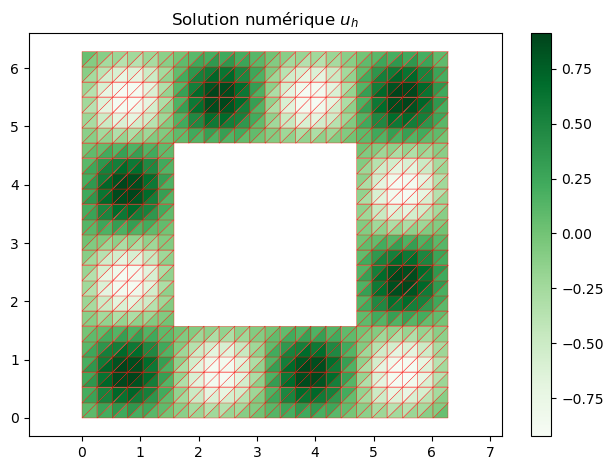

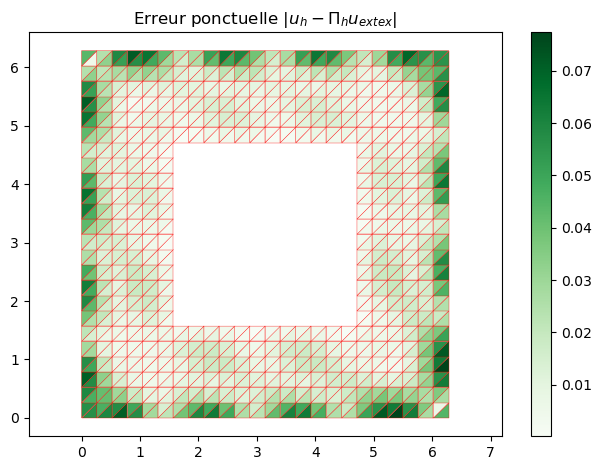

In [46]:
u_interp = np.array([uex(xy) for xy in vtx])                          #l’opérateur d’interpolation global.
error_vals = np.abs(u_h - u_interp)

PlotApproximation(vtx, elt, u_h, title="Solution numérique $u_h$")
# PlotApproximation(vtx, elt, u_interp, title="Solution exacte $u_h$")
PlotApproximation(vtx, elt, error_vals, title="Erreur ponctuelle $|u_h - \Pi_h u_{\text{ex}}|$")

### (d)

Tracer la convergence des deux erreurs :

$$
\frac{\|u_h - \Pi_h u_{\text{ex}}\|_{L^2(\Omega)}}{\|\Pi_h u_{\text{ex}}\|_{L^2(\Omega)}}, \quad
\frac{\|u_h - \Pi_h u_{\text{ex}}\|_{H^1(\Omega)}}{\|\Pi_h u_{\text{ex}}\|_{H^1(\Omega)}} \tag{6}
$$

par rapport au paramètre de maillage \\( h \\) pour divers raffinements uniformes du maillage.  
Quel est l’ordre de convergence pour les deux erreurs ?

In [48]:
def compute_L2_error(vtx, elt, uh, u_interp):
    error_sq = 0
    norm_sq = 0
    for tri in elt:
        x0, x1, x2 = vtx[tri[0]], vtx[tri[1]], vtx[tri[2]]
        area = 0.5 * abs(np.cross(x1 - x0, x2 - x0))
        uh_val = (uh[tri[0]] + uh[tri[1]] + uh[tri[2]]) / 3
        interp_val = (u_interp[tri[0]] + u_interp[tri[1]] + u_interp[tri[2]]) / 3
        error_sq += area * (uh_val - interp_val)**2
        norm_sq += area * interp_val**2
    return np.sqrt(error_sq) / np.sqrt(norm_sq)

def compute_H1_error(vtx, elt, uh, u_interp):
    error_sq = 0
    norm_sq = 0
    for tri in elt:
        i, j, k = tri
        x0, x1, x2 = vtx[i], vtx[j], vtx[k]
        area = 0.5 * abs(np.cross(x1 - x0, x2 - x0))

        # Gradients des fonctions de base (forme affine)
        grad_phi = np.array([
            [x1[1] - x2[1], x2[0] - x1[0]],
            [x2[1] - x0[1], x0[0] - x2[0]],
            [x0[1] - x1[1], x1[0] - x0[0]],
        ]) / (2 * area)

        grad_uh = uh[i] * grad_phi[0] + uh[j] * grad_phi[1] + uh[k] * grad_phi[2]
        grad_interp = u_interp[i] * grad_phi[0] + u_interp[j] * grad_phi[1] + u_interp[k] * grad_phi[2]

        error_sq += area * np.dot(grad_uh - grad_interp, grad_uh - grad_interp)
        norm_sq += area * np.dot(grad_interp, grad_interp)

    return np.sqrt(error_sq) / np.sqrt(norm_sq)

In [49]:
def run_convergence_test(n_list, f, grad_u_ex_N, uex):
    hs = []
    err_L2 = []
    err_H1 = []

    for n in n_list:
        vtx, elt = GenerateMesh(n)
        h = 2 * np.pi / (4 * n)        # Taille du maillage h
        hs.append(h)

        # Assemblage des matrices du système (K, M, mu, B_f, B_n, etc.)
        K = Rig(vtx, elt)
        M = Mass_mu(vtx, elt)
        A = K + M

        B_f = assemble_B_f(vtx, elt, f)
        B_n = assemble_B_neumann(vtx, elt, grad_u_ex_N)
        F = B_f + B_n

        # Application des conditions de Dirichlet
        belt = Boundary(elt)
        gamma_n = extract_GammaN(vtx, belt)
        gamma_d = extract_GammaD(vtx, belt)
        boundary_nodes = np.unique(np.array(gamma_d).flatten())

        A = csr_matrix(A).tolil()
        for node in boundary_nodes:
            A[node, :] = 0
            A[node, node] = 1
            F[node] = 0
        A = A.tocsr()

        # Résolution du système
        u_h = spsolve(A, F)
        # Interpolation de la solution exacte
        u_interp = np.array([uex(xy) for xy in vtx])

        e_L2 = compute_L2_error(vtx, elt, u_h, u_interp)
        e_H1 = compute_H1_error(vtx, elt, u_h, u_interp)

        err_L2.append(e_L2)
        err_H1.append(e_H1)

    # Affichage des courbes d'erreurs
    plt.loglog(hs, err_L2, '-o', label="$L^2$ relative error")
    plt.loglog(hs, err_H1, '-s', label="$H^1$ relative error")
    plt.gca().invert_xaxis()
    plt.xlabel("$h$")
    plt.ylabel("Erreur relative")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.title("Convergence des erreurs normalisées")
    plt.tight_layout()
    plt.show()

    # Calcul des ordres de convergence par régression logarithmique
    p_L2 = np.polyfit(np.log(hs), np.log(err_L2), 1)[0]
    p_H1 = np.polyfit(np.log(hs), np.log(err_H1), 1)[0]
    print(f"Ordre de convergence L2 : {abs(p_L2):.2f}")
    print(f"Ordre de convergence H1 : {abs(p_H1):.2f}")

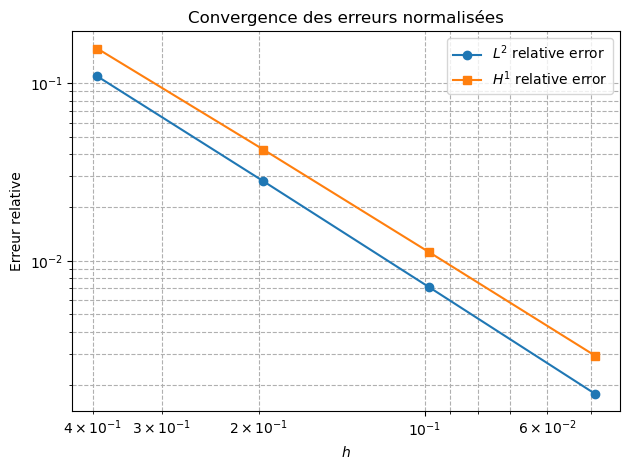

Ordre de convergence L2 : 1.98
Ordre de convergence H1 : 1.92


In [50]:
run_convergence_test([4, 8, 16, 32], f, grad_u_ex_N, uex)